<a href="https://colab.research.google.com/github/saharshayegan/Twitter_LDA_text_analysis/blob/main/English_Twitter_LDA_TextAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Run this and reset the runtime. Then proceed.
!pip install --upgrade pandas==1.2
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Installing and importing

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim import matutils

from collections import defaultdict
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
### Installing Stuff

In [ ]:
# Package is in detached-head mode. Clone from Github, commit latest changes and run setup.py
! git clone https://github.com/bmabey/pyLDAvis
%cd pyLDAvis
! python setup.py build
! python setup.py install
%cd ..

In [ ]:
! python3.7 -m pip install funcy
! pip install funcy
import sys
sys.path.insert(0,'/usr/local/lib/python3.7/dist-packages/funcy-1.17-py3.7.egg')
import funcy
# !pip install --upgrade pandas==1.2


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
import pyLDAvis.gensim_models as gensimvis

## Base

In [7]:
import pandas as pd

filename= "/content/drive/MyDrive/Colab Notebooks/thesis/diseases.txt"
with open(filename) as f:
    diseases = [line.rstrip() for line in f]
print(diseases)

path = r'/content/drive/MyDrive/Colab Notebooks/thesis/' # use your path

# diseases 

['COPD', 'Diabetes', 'Arthritis', 'Obesity', 'Migraine', 'Heart Diseases', 'Asthma', 'Depression', 'PTSD', 'Cancer']


In [8]:
diseases.append('cardiovascular')

In [9]:
diseases.remove('Heart Diseases')

In [10]:
diseases

['COPD',
 'Diabetes',
 'Arthritis',
 'Obesity',
 'Migraine',
 'Asthma',
 'Depression',
 'PTSD',
 'Cancer',
 'cardiovascular']

## Text preparation/cleanup for analysis

In [ ]:
# I've run this before. don't run it again.
for disease in diseases:
  print(disease)
  df = pd.read_csv(path+disease+'_tweets.csv', index_col=None, header=0)
  tweet_list_raw = df['Text'].tolist()
  # Text cleaning
  # Remove http
  link_pttrn = r"http\S+"
  tweet_list = [re.sub(link_pttrn, "", tweet) for tweet in tweet_list_raw]

  # Remove non-letter sequences
  nl_pttrn = r"[^a-zA-Z']+"
  tweet_list = [re.sub(nl_pttrn, " ", tweet) for tweet in tweet_list]

  # Lower case
  tweet_list = [tweet.lower() for tweet in tweet_list]

  # Remove white space at beginning and end of document
  ws_pttrn = r"(^ | $)"
  tweet_list = [re.sub(ws_pttrn, "", tweet) for tweet in tweet_list]
  # tweet_list[10:20]
  # Pre-processing
  # print(tweet_list_raw[501])
  # Post-processing
  # print(tweet_list[501])


  import nltk
  # STOPWORDS
  nltk_stop_words = set(stopwords.words("english"))
  def tokenize(tweet):
      return [token for token in simple_preprocess(tweet) if token not in nltk_stop_words]
  tweets = [tokenize(tweet) for tweet in tweet_list]
  tweets
  tweets[501]
  frequency = defaultdict(int)
  for tweet in tweets:
      for token in tweet:
          frequency[token] += 1
  freq_series = pd.Series(frequency)
  # freq_series.sort_values(ascending=False)[0:10]
  days = ['mon','tue','wed','thu','fri','sat','sun']
  months = ['jan', 'feb', 'mar','apr','may','jun',\
          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

  irrel = ["rt", "amp"]
  uncommon_words = [w[0] for w in frequency.items() if w[1]<5]
  two_letter = [w[0] for w in frequency.items() if len(w[0])< 3]

  removed = uncommon_words + two_letter +days + months + irrel  
  print('Text is cleaned')

  # Process does take about 10-15 minutes, so the output is saved and loaded
  tweets_clean = [[token for token in tweet if token not in removed] for tweet in tweets]
  tweets_clean[501]
  pickle_out = open(path+disease+"_clean_final.pickle", "wb")
  pickle.dump(tweets_clean, pickle_out)
  pickle_out.close()

cardiovascular
Text is cleaned


## LDA and Visualization

### The LDA and Visualize methods

In [26]:
def run_lda(corpus, dictionary, clusters,path,disease):
  # Runtime about 5 mins
  print('Trying to run the models')
  tweet_topics = LdaModel(corpus = corpus,
                        id2word = dictionary,
                        num_topics = clusters,
                        passes= 10)
  pickle_out2 = open(path+disease+"_ffinalmodel_{}clusters_split.pickle".format(clusters), "wb")
  pickle.dump(tweet_topics, pickle_out2)
  pickle_out2.close()
  return tweet_topics

In [27]:
def visualize(tweet_topics, corpus, dictionary, clusters, path, disease):
  ### Visualizing
  vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)
  # print(vis_data)
  file = open(path+disease+'_twitter-LDA_{}clusters_split.txt'.format(clusters), 'w')
  file.write(str(vis_data))
  file.close()
  import pyLDAvis
  pyLDAvis.display(vis_data)
  pyLDAvis.save_html(vis_data, path+disease+'_twitter-LDA_{}clusters_split.html'.format(clusters))

In [ ]:
#  'COPD' 8
#  'Diabetes' 8
#  'Arthritis' 8
#  'Obesity' 6
#  'Migraine' 8
#  'Asthma' 8
#  'Depression' 8
#  'PTSD' 8
#  'Cancer' 8
#  'cardiovascular' 7

import pickle

disease = 'cardiovascular'
clusters = 7
lda_model = pickle.load(open(path+disease+"_ffinalmodel_{}clusters_split.pickle".format(clusters), 'rb'))

l = lda_model.show_topics(num_words = 20, formatted = False)
counter = 1
for tup in l:
  print(counter)
  for pair in tup[1]:
    print(pair[0], end=', ')
  counter +=1
  print()
print()

### For each topic:

In [ ]:
# train, test = train_test_split(df, test_size=0.2)

In [24]:
# I have done this before. no need to do it again
# from sklearn.model_selection import train_test_split

# for disease in diseases:
#   tweets_clean = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )

#   train, test = train_test_split(tweets_clean, test_size=0.2)

#   pickle_out = open(path+disease+"_clean_final_train.pickle", "wb")
#   pickle.dump(train, pickle_out)
#   pickle_out.close()

#   pickle_out = open(path+disease+"_clean_final_test.pickle", "wb")
#   pickle.dump(train, pickle_out)
#   pickle_out.close()

In [34]:
import pickle

for disease in diseases:
  tweets_clean = pickle.load(open(path+disease+"_clean_final_train.pickle", "rb" ))
  train = pickle.load(open(path+disease+"_clean_final_train.pickle", "rb" ))

  dictionary = corpora.Dictionary(tweets_clean)
  corpus = [dictionary.doc2bow(tweet) for tweet in train]

  # TASK
  # modele lda ba cluster 6,7,8 run shodan baraye dictionary jadid
  # baghie ro ham run kon

  # havaset bashe ke motasefane train o test ro dobare split kardi o ba ghabli fargh dare. 
  # har ja azashoon estefade shode ro bayad baz run koni

  # chon modelet jadide bayad elbow ro ham mojadad hesab koni

  # alan faghat Arthritis o migraine ba in halate jadid kalamatshun dar umade.
  # baghoi jadvalaye gozaresh ro por kon

  #Run batch LDA and cross fingers
  for clusters in range(6,7):
    run_lda(corpus, dictionary, clusters,path,disease)

    tweet_topics = pickle.load(open(path+disease+"_ffinalmodel_{}clusters_split.pickle".format(clusters), "rb" ) )
    for i, topic in enumerate(tweet_topics.print_topics(15)):
        print (i, topic)

    ### Visualizing
    visualize(tweet_topics, corpus, dictionary, clusters, path, disease)


Trying to run the models
0 (0, '0.066*"copd" + 0.027*"covid" + 0.011*"get" + 0.009*"like" + 0.008*"got" + 0.007*"hospital" + 0.007*"know" + 0.007*"people" + 0.007*"mask" + 0.007*"mom"')
1 (1, '0.061*"copd" + 0.018*"used" + 0.017*"patients" + 0.016*"smoking" + 0.012*"older" + 0.012*"airway" + 0.011*"age" + 0.010*"cell" + 0.010*"also" + 0.010*"treat"')
2 (2, '0.066*"copd" + 0.041*"disease" + 0.035*"chronic" + 0.029*"asthma" + 0.028*"lung" + 0.024*"pulmonary" + 0.021*"obstructive" + 0.014*"respiratory" + 0.012*"treatment" + 0.012*"cancer"')
3 (3, '0.095*"copd" + 0.025*"patients" + 0.017*"asthma" + 0.013*"pulmonary" + 0.010*"study" + 0.010*"new" + 0.008*"health" + 0.008*"care" + 0.008*"read" + 0.007*"rehabilitation"')
4 (4, '0.072*"copd" + 0.016*"risk" + 0.015*"people" + 0.013*"air" + 0.013*"asthma" + 0.009*"first" + 0.008*"exposure" + 0.008*"high" + 0.007*"smoking" + 0.007*"death"')
5 (5, '0.065*"copd" + 0.009*"march" + 0.008*"health" + 0.008*"care" + 0.008*"asthma" + 0.008*"free" + 0.007

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

for disease in diseases:
  test =  pickle.load(open(path+disease+"_clean_final_train.pickle", "rb" ))
  tweets_clean = test
  dictionary = corpora.Dictionary(tweets_clean)
  corpus = [dictionary.doc2bow(tweet) for tweet in tweets_clean]

  perplexity = []
  for clusters in range(2,10):
    lda_model = pickle.load(open(path+disease+"_ffinalmodel_{}clusters_split.pickle".format(clusters), "rb" ) )
    perplexity.append(math.exp(lda_model.log_perplexity(corpus)))
  print(perplexity)

  fig, ax = plt.subplots()
  ax.plot(range(2,10), perplexity, linewidth=2.0, color='g')
  ax.set(xlim=(2, 9), xticks=np.arange(2, 10),
          ylim=(min(perplexity)*0.98, max(perplexity)*1.02))
  plt.title(disease+'- Perplexity of Train Set')
  plt.xlabel("Clusters")
  plt.ylabel("Perplexity")
  plt.grid()
  plt.savefig(path+disease+"_fig_train.png")
  plt.show()

In [ ]:
perplexity

In [ ]:
print(perplexity)

### For all topics together

In [ ]:
import pandas as pd
import pickle

path = r'/content/drive/MyDrive/Colab Notebooks/thesis/' # use your path

all_tweets = []

for disease in diseases:
  tweets = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )
  all_tweets+= tweets

dictionary = corpora.Dictionary(all_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in all_tweets]
clusters = 6

lda_model = run_lda(corpus, dictionary, clusters,path,'all')

visualize(lda_model, corpus, dictionary, clusters, path, 'all')

### Predicting

In [ ]:
#  predicting new text which is in text dataframe  
disease = 'Asthma'
clusters = 8

tweets_clean =  pickle.load(open(path+disease+"_clean_final.pickle", "rb" ))
dictionary = corpora.Dictionary(tweets_clean)
corpus = [dictionary.doc2bow(tweet) for tweet in tweets_clean]
ldamodel = pickle.load(open(path+disease+"_ffinalmodel_{}clusters_split.pickle".format(clusters), "rb" ) )

tops = ldamodel.get_document_topics(corpus)


topic_probability = []
i=0
for i in range(0, len(tops)):
  t = tops[i]
  new_t = [0]*clusters
  for tup in t:
    new_t[tup[0]]=tup[1]
  topic_probability.append(new_t)

columns = []
for i in range(0,clusters):
  columns.append('Topic {}'.format(i))

results_test = pd.DataFrame(topic_probability,columns=columns)

results_test.to_csv(path+disease+'_whole_predict_results.csv', index=True, header=True)


In [33]:
from collections import Counter 

# columns = []
# for i in range(0,clusters):
#   columns.append('Topic {}'.format(i+1))
print(columns)

results_test['maxValueIndex'] = results_test[columns].idxmax(axis = 1)

for column in columns:
  print(column)
  indices = results_test[results_test['maxValueIndex']==column].index
  new_tweets_clean = [tweets_clean[index] for index in indices]
  words_count = pd.DataFrame(Counter(c for clist in new_tweets_clean for c in clist).most_common(250))
  i = 0
  for w in words_count[0]:
    if i <20:
      print(w,end=', ')
    else:
      break
    i+=1
  print()

results_test.to_csv(path+disease+'_whole_predict_results_labeled.csv', index=True, header=True)


['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']
Topic 0
migraine, migraines, get, really, sleep, give, hate, day, like, fuck, worst, finally, still, would, days, sick, attack, got, ever, better, 
Topic 1
migraine, migraines, pain, today, like, get, work, know, take, feel, day, headache, back, head, brain, want, fucking, getting, days, even, 
Topic 2
migraine, migraines, bad, getting, going, get, week, really, one, got, back, headache, today, day, need, stream, every, like, much, tonight, 
Topic 3
migraine, migraines, got, time, day, today, good, night, like, get, woke, see, last, head, new, think, since, headache, back, days, 
Topic 4
migraine, day, migraines, today, like, worst, still, morning, another, woke, get, work, literally, life, away, days, much, feel, every, since, 
Topic 5
migraine, migraines, like, get, feel, one, day, gonna, days, sleep, two, today, take, think, people, pain, hours, still, woke, hate, 
Topic 6
migraine, migraines, d

In [114]:
results_test

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,maxValueIndex
0,0.017868,0.017868,0.017864,0.874909,0.017867,0.017868,0.017874,0.017882,Topic 3
1,0.025016,0.025009,0.025015,0.824850,0.025007,0.025079,0.025003,0.025019,Topic 3
2,0.000000,0.184013,0.000000,0.633305,0.000000,0.000000,0.000000,0.134513,Topic 3
3,0.000000,0.000000,0.851376,0.000000,0.000000,0.000000,0.000000,0.098573,Topic 2
4,0.025009,0.025022,0.025022,0.824813,0.025005,0.025010,0.025100,0.025019,Topic 3
...,...,...,...,...,...,...,...,...,...
9995,0.278957,0.140475,0.015647,0.265810,0.015647,0.140961,0.126837,0.015666,Topic 0
9996,0.129633,0.211898,0.211201,0.297335,0.012523,0.112347,0.012523,0.012539,Topic 3
9997,0.546405,0.146830,0.000000,0.105505,0.000000,0.000000,0.165460,0.000000,Topic 0
9998,0.111015,0.222177,0.000000,0.368010,0.000000,0.273774,0.000000,0.000000,Topic 3


copd, asthma, disease, covid, lung, patients, pulmonary, chronic, people, health, respiratory, obstructive, help, cancer, treatment, get, risk, like, care, new, 

# TFIDF


### YOU NEED TEST AND TRAIN DATA.

In [ ]:
import pickle
import numpy as np
import pandas as pd 
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

for disease in ['COPD']:#diseases:
  tweets_clean = pickle.load(open(path+disease+"_clean_final.pickle", "rb" ) )

  # You need to change the cleaning process. 
  # or concatinate the tokens to create the entences. 
  # this will not work with tokens. it gets a column of sentences in your df.
  text_content = tweets_clean
  for i in range(len(text_content)):
    s = ''
    for token in text_content[i]:
      s += token + ' '
    text_content[i] = s
  vector = TfidfVectorizer(stop_words = 'english') #Dont need stop words
  tfidf = vector.fit_transform(text_content)
  print(text_content[0:10])

['pulm wtchp cce stony brook first responder medical records drs notes discussing social history smoker smoker copd last yrs wrote many final reports shared ', 'would say prayer father triple year ago still dealing severe nerve pain also copd broke rib coughing prayers definitely needed tired seeing dad much pain ', 'airway clinical research center research programs asthma copd sarcoidosis cystic fibrosis along current programs sponsored nih pharmaceutical industry position ', 'differentiating asthma copd imaging machine pulmonology machinelearning ', 'clinical implications bronchodilator testing diagnosing differentiating copd asthma copd overlap ', 'chronic depression high blood pressure chronic asthma bronchitis copd alot ', 'person copd feels self conscious bringing oxygen hearts child best way strike conversation daughter law ', 'able walk around easier another days back able get things done remember much last week except hell plus finally quit smoking days never period scary shit

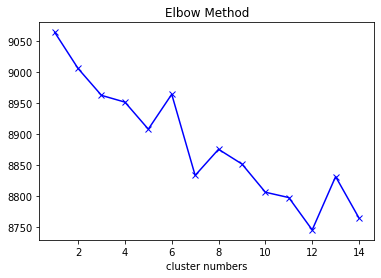

In [ ]:
## YOU SHOULD ALSO DO ALL THE REST FOR EACH TOPIC

# 3. Using elbow method to decide cluster number
# Introduction to elbow method

K = range(1,15)
SSE = []
for k in K:
    kmeans = MiniBatchKMeans(n_clusters = k,batch_size = 300)
    kmeans.fit(tfidf)
    SSE.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [ ]:
# 5. Using MiniBatchKMean to cluster
# Comparison of the K-Means and MiniBatchKMeans clustering algorithms

k = 4
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:15]:
        word_list.append(terms[j])
    print(word_list) 

cluster0:
['covid', 'copd', 'mom', 'got', 'home', 'hospital', 'dad', 'mask', 'old', 'years', 'positive', 'time', 'year', 'people', 'tested']
cluster1:
['asthma', 'copd', 'disease', 'chronic', 'obstructive', 'lung', 'pulmonary', 'used', 'patients', 'respiratory', 'treat', 'treatment', 'diseases', 'bronchitis', 'rotacaps']
cluster2:
['copd', 'help', 'patients', 'disease', 'lung', 'pulmonary', 'people', 'health', 'study', 'smoking', 'chronic', 'risk', 'new', 'care', 'like']
cluster3:
['know', 'living', 'copd', 'youtube', 'people', 'lung', 'like', 'let', 'need', 'conditions', 'disease', 'fiberglass', 'friends', 'asthma', 'support']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# 7. Topic modeling

# Here I use NMF instead of LDA because LDA's calculation is time-consuming.

# The major topics consist of politics, society, finance and internetional affairs, which is quite similiar to our cluster resu

from sklearn.decomposition import NMF

nmf  = NMF(n_components = 4)
nmf.fit(tfidf)
for i in range(0,k):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-16:-1]:
        word_list.append(terms[j])
    print(word_list)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic0:
['learn', 'today', 'risk', 'new', 'care', 'know', 'like', 'cancer', 'patients', 'health', 'asthma', 'lung', 'people', 'help', 'covid']
Topic1:
['cancer', 'common', 'causes', 'heart', 'rehabilitation', 'respiratory', 'copd', 'smoking', 'bronchitis', 'emphysema', 'diseases', 'lung', 'obstructive', 'pulmonary', 'disease']
Topic2:
['rotahaler', 'tiova', 'device', 'capsules', 'dry', 'treat', 'inhalation', 'approves', 'powder', 'cipla', 'symbicort', 'treatment', 'fda', 'generic', 'rotacaps']
Topic3:
['rotacaps', 'disease', 'obstructive', 'treat', 'patients', 'years', 'airway', 'older', 'age', 'prevent', 'reversible', 'prevention', 'asthalin', 'bronchospasm', 'inhaler']


## Determine time evolution of tweets

In [ ]:
# extract all document-topic distritbutions to dictionnary
# document_key = list(tweet_df.date)
document_topic = {}

In [ ]:
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = tweet_topics.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp

In [ ]:
df = pd.DataFrame.from_dict(document_topic, orient='index')

In [ ]:
df.columns = ["Nuclear", "Professor_Crime", "Thaler_Nobel", "Cancer_Research", "Unionization", "Evening_Program", "Zimmer_FreeSpeech"]

In [ ]:
df.head(5)

In [ ]:
df.to_csv("/Users/Orest/Desktop/Big Data and Text Analytics/FP/timed_tweets.csv")

Graphs are produced with ggplot2 package in R.